In [11]:
import os
import sys

import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [2]:
sys.path.append('../')
from src.config import CFG
from src.dataset import Img_dataset, get_transform
from src.model import Generator, Discriminator
from src.utils import show_image

(720, 960, 3)


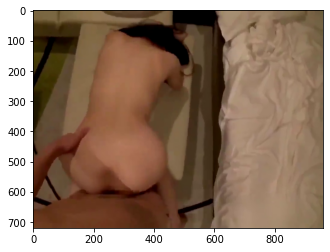

In [3]:
filename = sorted(os.listdir(CFG.IMG_DIR))[2000]

show_image(f'{CFG.IMG_DIR}/{filename}')

## データセットの中身を確認

In [4]:
# check dataset
paths = [f'{CFG.IMG_DIR}/{filename}' for path in os.listdir(CFG.IMG_DIR)]
train_dataset = Img_dataset(paths, train_tran=get_transform(TRAIN=False),
                            val_tran=get_transform(TRAIN=True))

for i in range(1):
    before = train_dataset[i][0].numpy().astype(int).transpose(1, 2, 0)
    after = train_dataset[i][1].numpy().astype(int).transpose(1, 2, 0)
    print(before.shape, after.shape)
    

(720, 960, 3) (720, 960, 3)


In [5]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=False)


## model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
torch.backends.cudnn.benchmark = True # autotunerが高速化

In [8]:
def train():
    # check dataset
    paths = [f'{CFG.IMG_DIR}/{path}' for path in os.listdir(CFG.IMG_DIR)]
    train_dataset = Img_dataset(paths, train_tran=get_transform(TRAIN=False),
                                val_tran=get_transform(TRAIN=True))
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)

    model_G, model_D = Generator(), Discriminator()
    model_G, model_D = nn.DataParallel(model_G), nn.DataParallel(model_D)
    model_G, model_D = model_G.to(device), model_D.to(device)
    params_G = torch.optim.Adam(model_G.parameters(),
                lr=0.0002, betas=(0.5, 0.999))
    params_D = torch.optim.Adam(model_D.parameters(),
                lr=0.0002, betas=(0.5, 0.999))
    
    if os.path.exists(CFG.trained_param):
        states = torch.load(CFG.trained_param)
        model_G.load_state_dict(states)
        
    
    # 損失関数
    bce_loss = nn.BCEWithLogitsLoss()
    mae_loss = nn.L1Loss()

    # ロスを計算するためのラベル変数 (PatchGAN)
    # aspect ratio 4:3
    ones = torch.ones(CFG.xsize, 1, 22, 30).to(device)
    zeros = torch.zeros(CFG.ysize, 1, 22, 30).to(device)

    # エラー推移
    result = {}
    result["log_loss_G_sum"] = []
    result["log_loss_G_bce"] = []
    result["log_loss_G_mae"] = []
    result["log_loss_D"] = []

    for i in tqdm(range(200)):
        print(f'epoch: {i+1}')
        log_loss_G_sum, log_loss_G_bce, log_loss_G_mae, log_loss_D = [], [], [], []

        for num, (high_image, low_image) in enumerate(train_loader):
            batch_len = len(high_image)
            high_image /= 255
            high_image, low_image = high_image.to(device), low_image.to(device)

            # Gの訓練
            # 偽のカラー画像を作成
            fake_color = model_G(low_image)

            # 偽画像を一時保存
            fake_color_tensor = fake_color.detach()

            # 偽画像を本物と騙せるようにロスを計算
            LAMBD = 100.0 # BCEとMAEの係数
            out = model_D(torch.cat([fake_color, low_image], dim=1))
            loss_G_bce = bce_loss(out, ones[:batch_len])
            loss_G_mae = LAMBD * mae_loss(fake_color, high_image)
            loss_G_sum = loss_G_bce + loss_G_mae
            del fake_color

            log_loss_G_bce.append(loss_G_bce.item())
            log_loss_G_mae.append(loss_G_mae.item())
            log_loss_G_sum.append(loss_G_sum.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_G_sum.backward()
            params_G.step()

            # Discriminatoの訓練
            # 本物のカラー画像を本物と識別できるようにロスを計算
            real_out = model_D(torch.cat([high_image, low_image], dim=1))
            loss_D_real = bce_loss(real_out, ones[:batch_len])

            # 偽の画像の偽と識別できるようにロスを計算
            fake_out = model_D(torch.cat([fake_color_tensor, low_image], dim=1))
            loss_D_fake = bce_loss(fake_out, zeros[:batch_len])

            # 実画像と偽画像のロスを合計
            loss_D = loss_D_real + loss_D_fake
            log_loss_D.append(loss_D.item())

            # 微分計算・重み更新
            params_D.zero_grad()
            params_G.zero_grad()
            loss_D.backward()
            params_D.step()
            
            

        result["log_loss_G_sum"].append(statistics.mean(log_loss_G_sum))
        result["log_loss_G_bce"].append(statistics.mean(log_loss_G_bce))
        result["log_loss_G_mae"].append(statistics.mean(log_loss_G_mae))
        result["log_loss_D"].append(statistics.mean(log_loss_D))
        print(f"log_loss_G_sum = {result['log_loss_G_sum'][-1]} " +
              f"({result['log_loss_G_bce'][-1]}, {result['log_loss_G_mae'][-1]}) " )
        print(f"log_loss_D = {result['log_loss_D'][-1]}")

        # 画像を保存
        if not os.path.exists(CFG.OUTPUT_IMG):
            os.mkdir(CFG.OUTPUT_IMG)
        # 生成画像を保存
        torchvision.utils.save_image(conv_scale(fake_color_tensor[:min(batch_len, 100)]),
                                f"{CFG.OUTPUT_IMG}/fake_epoch_{i:03}.png",
                                    )
        torchvision.utils.save_image(conv_scale(high_image[:min(batch_len, 100)]),
                                f"{CFG.OUTPUT_IMG}/real_epoch_{i:03}.png",
                                    )

        # モデルの保存
        if not os.path.exists(CFG.OUTPUT_MODEL):
            os.mkdir(CFG.OUTPUT_MODEL)
        if i % 10 == 0 or i == 199:
            torch.save(model_G.state_dict(), f"{CFG.OUTPUT_MODEL}/gen_{i:03}.pytorch")                        
            torch.save(model_D.state_dict(), f"{CFG.OUTPUT_MODEL}/dis_{i:03}.pytorch")                        

#     # ログの保存
#     with open("stl_color/logs.pkl", "wb") as fp:
#         pickle.dump(result, fp)

In [12]:
train()

epoch: 1



KeyboardInterrupt: 